<a href="hhttps://colab.research.google.com/github/WinetraubLab/coregister-z-pattern/blob/main/coregister_z_pattern.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-z-pattern/blob/main/coregister_z_pattern.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
This notebook will compute the best plane fit based on photobleach lines "z-pattern".

See photobleach pattern with the z-pattern numbers on it

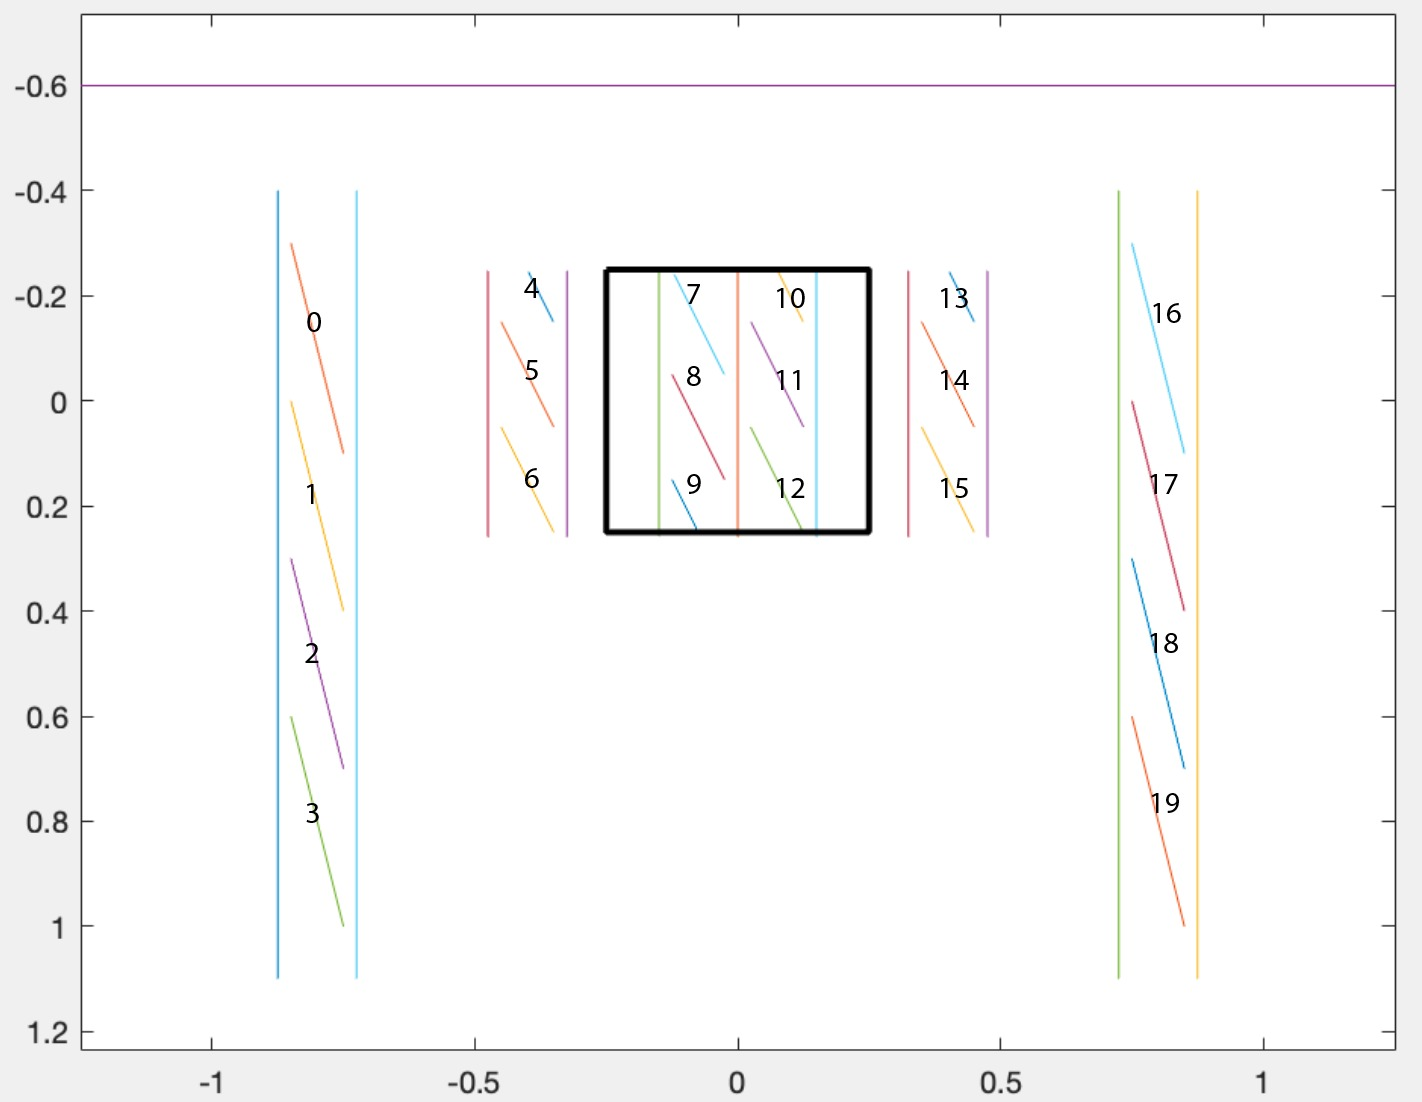

In [ ]:
#@title Inputs

# Dict for each z pattern that is visible in the image (0,1,...) provide
# xy position of each point: [[Ax,Ay],[Bx, By], [Cx, Cy]]
silde_name = 'S5s1'
fluorescent_image_points_uv_pix = {
    2:[[37, 149], [157,128], [245, 89]],
    3:[[1026, 202], [1161, 216],[1225, 218]],
    5:[[436, 110], [497,106], [644,116]],
    6:[[644,116], [716,118], [844,160]],
}

In [ ]:
# @title Environment Setup
import numpy as np
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')

!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane_elastic import FitPlaneElastic
from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib.ticker import ScalarFormatter

%cd ..

Mounted at /content/drive/
Cloning into 'coregister-xy'...
remote: Enumerating objects: 1366, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 1366 (delta 188), reused 124 (delta 110), pack-reused 1076 (from 2)
Receiving objects: 100% (1366/1366), 23.54 MiB | 18.59 MiB/s, done.
Resolving deltas: 100% (852/852), done.
/content/coregister-xy
/content


In [ ]:
# @title Find xyz positions from the patterns provided

# Define the patterm (v2)
pattern_defs = {
    0: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':-0.800, 'y_offset_mm':-0.400, 'z_mm':0.040},
  1: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':-0.800, 'y_offset_mm':-0.100, 'z_mm':0.040},
  2: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':-0.800, 'y_offset_mm':0.200, 'z_mm':0.040},
  3: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':-0.800, 'y_offset_mm':0.500, 'z_mm':0.040},
  4: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':-0.400, 'y_offset_mm':-0.400, 'z_mm':0.065},
  5: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':-0.400, 'y_offset_mm':-0.200, 'z_mm':0.065},
  6: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':-0.400, 'y_offset_mm':0.000, 'z_mm':0.065},
  7: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':-0.075, 'y_offset_mm':-0.300, 'z_mm':0.040},
  8: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':-0.075, 'y_offset_mm':-0.100, 'z_mm':0.040},
  9: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':-0.075, 'y_offset_mm':0.100, 'z_mm':0.040},
  10: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':0.075, 'y_offset_mm':-0.400, 'z_mm':0.040},
  11: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':0.075, 'y_offset_mm':-0.200, 'z_mm':0.040},
  12: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':0.075, 'y_offset_mm':0.000, 'z_mm':0.040},
  13: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':0.400, 'y_offset_mm':-0.400, 'z_mm':0.065},
  14: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':0.400, 'y_offset_mm':-0.200, 'z_mm':0.065},
  15: {'L_mm':0.300, 'D_mm':0.150, 'x_offset_mm':0.400, 'y_offset_mm':0.000, 'z_mm':0.065},
  16: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':0.800, 'y_offset_mm':-0.400, 'z_mm':0.040},
  17: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':0.800, 'y_offset_mm':-0.100, 'z_mm':0.040},
  18: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':0.800, 'y_offset_mm':0.200, 'z_mm':0.040},
  19: {'L_mm':0.600, 'D_mm':0.150, 'x_offset_mm':0.800, 'y_offset_mm':0.500, 'z_mm':0.040},
}

# Returns x,y position of each of the z patern
def fit_z_pattern(AB, AC, pattern_def, alpha_deg=0):
  # Extract data from pattern
  L_mm = pattern_def['L_mm']
  D_mm = pattern_def['D_mm']
  x_offset_mm = pattern_def['x_offset_mm']
  y_offset_mm = pattern_def['y_offset_mm']
  z_mm = pattern_def['z_mm']

  # Convert alpha to radians
  alpha_rad = alpha_deg/180*np.pi
  p = AB/AC
  if p>1 or p<0:
    raise 'Not good'
  y_mm = (L_mm + D_mm*np.tan(alpha_rad))*p;

  # Compute point A, C (x,y)
  pt_A = np.array([x_offset_mm-D_mm/2 , y_offset_mm+y_mm, z_mm])
  pt_C = np.array([x_offset_mm+D_mm/2 , y_offset_mm+y_mm+D_mm*np.tan(alpha_rad), z_mm])

  # B is some sort of an average
  pt_B = pt_A + (pt_C-pt_A)*p

  # Compute pixel size
  pixel_size_mm = D_mm*np.cos(alpha_rad) / AC
  pixel_size_um = pixel_size_mm * 1000

  return (pt_A, pt_B, pt_C, pixel_size_um)

# Fit all patterns
def fit_all_patterns(alpha_deg):
  pt_As = []
  pt_Bs = []
  pt_Cs = []
  pixel_sizes_um = []
  project_errors_pix = []
  for pattern_id, abc_pix in fluorescent_image_points_uv_pix.items():
    # Compute AB, AC
    abc_pix = np.array(abc_pix)
    a_pix = np.array(abc_pix[0])
    b_pix = np.array(abc_pix[1])
    c_pix = np.array(abc_pix[2])

    centroid = abc_pix.mean(axis=0)
    direction = np.linalg.svd(abc_pix - centroid)[2][0]
    project = lambda p: centroid + np.dot(p - centroid, direction) * direction
    a_p_pix, b_p_pix, c_p_pix = project(a_pix), project(b_pix), project(c_pix)

    ab_pix = np.linalg.norm(a_p_pix - b_p_pix)
    ac_pix = np.linalg.norm(a_p_pix - c_p_pix)
    project_error_pix = np.mean([np.linalg.norm(a_pix - a_p_pix), np.linalg.norm(b_pix - b_p_pix), np.linalg.norm(c_pix - c_p_pix)])

    #print(f'{project_error_pix} ({a_pix},{a_p_pix}) ({b_pix},{b_p_pix}) ({c_pix},{c_p_pix})')

    pt_A, pt_B, pt_C, pixel_size_um = fit_z_pattern(ab_pix, ac_pix, pattern_defs[pattern_id], alpha_deg)
    pt_As.append(pt_A)
    pt_Bs.append(pt_B)
    pt_Cs.append(pt_C)
    project_errors_pix.append(project_error_pix)
    pixel_sizes_um.append(pixel_size_um)

  return (np.array(pt_As), np.array(pt_Bs), np.array(pt_Cs), np.mean(pixel_sizes_um), np.mean(project_errors_pix))

# Estimate Alpha
def estimate_alpha_deg(pt_As):
  x = pt_As[:,0]
  y = pt_As[:,1]
  x = x[~np.isnan(x)]
  y = y[~np.isnan(y)]

  # Check if there are enough points for linear regression
  if len(x) >= 2:
    # Perform linear regression
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    return np.atan(slope) * 180 / np.pi
  else:
    return np.nan

# Fit, estimate alpha and fit again
alpha_updated_deg = 0; # Start from default 0
for i in range(5):
  pt_As_mm, pt_Bs_mm, pt_Cs_mm, pixel_size_um, project_error_pix = fit_all_patterns(alpha_updated_deg)
  alpha_updated_deg = estimate_alpha_deg(pt_As_mm)


KeyError: 9

In [ ]:
# @title Plot the physical image

# Plotting
plt.figure(figsize=(10, 2))

for i in range(len(pt_As_mm)):
    # Vertical lines at A, B, C
    plt.axvline(pt_As_mm[i,0], color='r', linestyle='--', label='A' if i == 0 else "")
    plt.axvline(pt_Bs_mm[i,0], color='k', linestyle='--', label='B' if i == 0 else "")
    plt.axvline(pt_Cs_mm[i,0], color='b', linestyle='--', label='C' if i == 0 else "")

    plt.plot(pt_As_mm[i,0],pt_As_mm[i,2], color='r', marker='o', markersize=5)
    plt.plot(pt_Cs_mm[i,0],pt_Cs_mm[i,2], color='b', marker='o', markersize=5)

    # Annotations
    z_scale = np.max(pt_Cs_mm[:,2])
    plt.text(pt_As_mm[i,0], z_scale*0.2, f'y={pt_As_mm[i,1]:.3f}', fontsize=8)#, ha='center')
    plt.text(pt_Cs_mm[i,0], z_scale*0.8, f'y={pt_Cs_mm[i,1]:.3f}', fontsize=8)#, ha='center')

print(f'Alpha = {alpha_updated_deg:0.1f} [deg]')
print(f'Pixel size = {pixel_size_um:0.2f} [um/pix]')
print(f'How far ABC from being a line? {project_error_pix:0.1f} [pixels]')
print(f"x=0, y={0.5*(np.nanmean(pt_As_mm[:,1])+np.nanmean(pt_Cs_mm[:,1]))*1000:.0f}um")

plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
plt.ylim(0,z_scale)
plt.title(f"{silde_name} - View from Side")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

# Plot from the top
plt.plot(pt_As_mm[:,0], pt_As_mm[:,1], 'ro', label='A')
plt.plot(pt_Bs_mm[:,0], pt_Bs_mm[:,1], 'ko', label='B')
plt.plot(pt_Cs_mm[:,0], pt_Cs_mm[:,1], 'bo', label='C')
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title(f"{silde_name} - View from Top")
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# @title Compute mapping between fluorescent and physical points
# Concatinate all points to single structure
fluorescent_points_uv_pix = np.zeros((len(fluorescent_image_points_uv_pix)*3,2))
template_points_xyz_mm = np.zeros((len(fluorescent_image_points_uv_pix)*3,3))
for i, en in enumerate(fluorescent_image_points_uv_pix.items()):
    fluorescent_points_uv_pix[3*i+0,:] = en[1][0]
    fluorescent_points_uv_pix[3*i+1,:] = en[1][1]
    fluorescent_points_uv_pix[3*i+2,:] = en[1][2]
for i in range(len(pt_As_mm)):
    template_points_xyz_mm[3*i+0,:] = pt_As_mm[i,:]
    template_points_xyz_mm[3*i+1,:] = pt_Bs_mm[i,:]
    template_points_xyz_mm[3*i+2,:] = pt_Cs_mm[i,:]


smoothing = 0.001*0
use_elastic_fit = True

fps_elastic = []
fps_affine = []

fp = FitPlane.from_template_centers(fluorescent_points_uv_pix, template_points_xyz_mm, print_inputs = False)
fps_affine.append(fp)

fp = FitPlaneElastic(fluorescent_points_uv_pix, template_points_xyz_mm, smoothing=smoothing, print_inputs = False, consistency_check=False)
fps_elastic.append(fp)

if False:
  fps_elastic[0].plot_explore_anchor_points_fit_quality(
        "Elastic", use_elastic_fit=True,
        coordinate_system='physical' # Change to 'plane' to view in plane / out plane projections
        )
  fps_elastic[0].plot_explore_anchor_points_fit_quality(
        "Elastic", use_elastic_fit=True,
        coordinate_system='plane' # Change to 'plane' to view in plane / out plane projections
        )
  fps_elastic[0].plot_explore_anchor_points_fit_quality(
        "Affine", use_elastic_fit=False,
        coordinate_system='physical' # Change to 'plane' to view in plane / out plane projections
        )

fps_elastic[0].plot_explore_anchor_points_fit_quality(
      "Affine", use_elastic_fit=False,
      coordinate_system='plane' # Change to 'plane' to view in plane / out plane projections
      )